# Aula 4 - Métodos ensemble
### Bagging vs Boosting

Pra lembrar as principais diferenças entre os dois métodos de ensemble que estudamos:

<img src=https://pluralsight2.imgix.net/guides/81232a78-2e99-4ccc-ba8e-8cd873625fdf_2.jpg width=600>

## Gradient boosting

Além dos métodos que estudamos, há ainda outras classes de métodos de ensemble!

Em particular, a classe de modelos que se utilizam do procedimento de **gradient boosting**.

O gradient boosting também é baseado no princípio de boosting (utilização de weak learners sequencialmente adicionados de modo a **sequencialmente minimizar os erros cometidos**).

<img src=https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png width=600>

Mas este método implementa o boosting através de um **gradiente** explícito.

A ideia é que caminhemos na direção do **erro mínimo** de maneira iterativa **passo a passo**.

Este caminho se dá justamente pelo **gradiente** da **função de custo/perda**, que mede justamente os erros cometidos.

<img src=https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif width=400>

Este método é conhecido como:

### Gradiente descendente


Deixei em ênfase porque este será um método de **enorme importância** no estudo de redes neurais (e é, em geral, um método de otimização muito utilizado).

O objetivo geral do método é bem simples: determinar quais são os **parâmetros** da hipótese que minimizam a função de custo/perda. Para isso, o método "percorre" a função de erro, indo em direção ao seu mínimo (e este "caminho" feito na função se dá justamente pela **determinação iterativa dos parâmetros**, isto é, **a cada passo, chegamos mais perto dos parâmetros finais da hipótese**, conforme eles são ajustados aos dados.

> **Pequeno interlúdio matemático:** o gradiente descendente implementado pelo gradient boosting é, na verdade, um **gradiente descendente funcional**, isto é, desejamos encontrar não um conjunto de parâmetros que minimiza o erro, mas sim **introduzir sequencialmente weak learners (hipótese simples) que minimizam o erro**. Desta forma, o gradient boosting minimiza a função de custo ao ecolher iterativamente hipóteses simples que apontam na direção do mínimo, neste espaço funcional.

Apesar do interlúdio acima, não precisamos nos preocupar muito com os detalhes matemáticos: o que importa é entender que no caso do gradient boosting, há alguns pontos importantes:

- Uma **função de custo/perda (loss)** é explicitamente minimizada por um procedimento de gradiente;

- O gradiente está relacionado com o procedimento de **encadeamento progressivo entre weak learners**, seguindo a ideia do boosting.

Pra quem quiser saber um pouco mais de detalhes (e se aventurar na matemática), sugiro [este post](https://www.gormanalysis.com/blog/gradient-boosting-explained/) ou então [este site](https://explained.ai/gradient-boosting/), que contém vários materiais ótimos para entender o método com todos os detalhes matemáticos.

Os [vídeos do StatQuest](https://www.youtube.com/playlist?list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6) também são uma boa referência!



As classes do sklearn são:

- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

E os principais hiperparâmetros a serem ajustados são:

- `n_estimators` : novamente, o número de weak learners encadeados.

- `learning_rate` : a constante que multiplica o gradiente no gradiente descendente. Essencialmente, controla o "tamanho do passo" a ser dado em direção ao mínimo.

Segundo o próprio [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting): "*Empirical evidence suggests that small values of `learning_rate` favor better test error. The lireature recommends to set the learning rate to a small constant (e.g. `learning_rate <= 0.1`) and choose `n_estimators` by early stopping.*"

Ainda sobre a learning rate, as ilustrações a seguir ajudam a entender sua importância:

<img src=https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png width=700>

<img src=https://cdn-images-1.medium.com/max/1440/0*A351v9EkS6Ps2zIg.gif width=500>

Vamos treinar nosso classificador baseline de gradient boosting:

In [2]:
# importar as bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import GradientBoostingClassifier


In [10]:
# copiando o pipeline da aula anterior
def pipe_pre_process_german():
    #carregar os dados -> data ingestion
    df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

    # Definir quem são as variáveis independentes e a variável dependente
    X = df.drop(columns="Risk")
    y = df["Risk"]

    # Particiona os dados a fim de poder avaliar o modelo ao fim do processo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # EDA -> Preprocessamento de dados
    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                                  ("min_max", MinMaxScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                  ("onehot", OneHotEncoder())])

    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return pre_processador, X_train, y_train, X_test, y_test

In [7]:
def metricas_classificacao(estimator):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))


    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))
    


Métricas de avaliação de treino:
[[161  79]
 [ 13 547]]


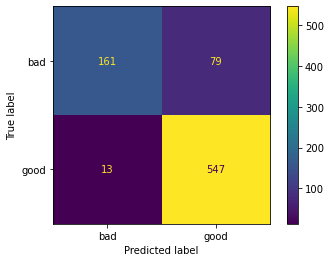

              precision    recall  f1-score   support

         bad       0.93      0.67      0.78       240
        good       0.87      0.98      0.92       560

    accuracy                           0.89       800
   macro avg       0.90      0.82      0.85       800
weighted avg       0.89      0.89      0.88       800


Métricas de avaliação de teste:
[[ 28  32]
 [ 12 128]]


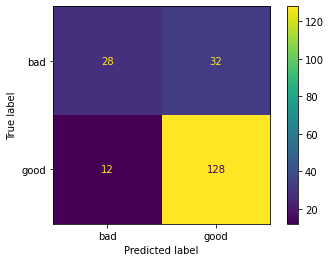

              precision    recall  f1-score   support

         bad       0.70      0.47      0.56        60
        good       0.80      0.91      0.85       140

    accuracy                           0.78       200
   macro avg       0.75      0.69      0.71       200
weighted avg       0.77      0.78      0.77       200



In [31]:
pre_processador, X_train, y_train, X_test, y_test = pipe_pre_process_german()

# Pipeline final

pipe_gb = Pipeline([('pre_processador', pre_processador), 
                    ('gb', GradientBoostingClassifier(random_state=420))])
# loss='log_loss', learning_rate=0.1, n_estimators=100

# treinar o modelo
pipe_gb.fit(X_train, y_train)

# avaliar o modelo
metricas_classificacao(pipe_gb)

Alterar alguns hiperâmetros:

learning_rate=0.1 -> learning_rate=1


Métricas de avaliação de treino:
[[240   0]
 [  0 560]]


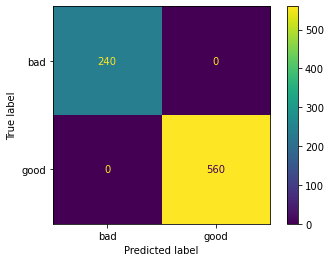

              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       240
        good       1.00      1.00      1.00       560

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Métricas de avaliação de teste:
[[ 34  26]
 [ 20 120]]


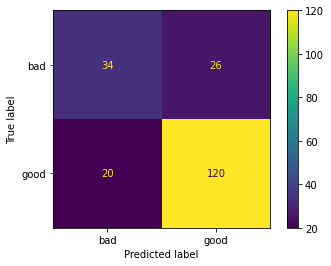

              precision    recall  f1-score   support

         bad       0.63      0.57      0.60        60
        good       0.82      0.86      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.76      0.77      0.77       200



In [32]:
pipe_gb = Pipeline([('pre_processador', pre_processador),
                    ('gb',
                     GradientBoostingClassifier(random_state=420,
                                                learning_rate=1,
                                                n_estimators=100))])

# treinar o modelo
pipe_gb.fit(X_train, y_train)

# avaliar o modelo
metricas_classificacao(pipe_gb)

Alterar alguns hiperâmetros:

learning_rate=0.1 -> learning_rate=0.01


Métricas de avaliação de treino:
[[ 19 221]
 [  1 559]]


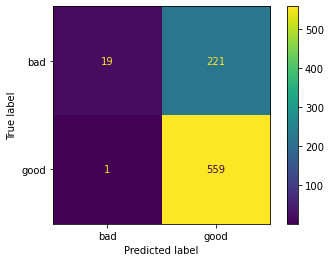

              precision    recall  f1-score   support

         bad       0.95      0.08      0.15       240
        good       0.72      1.00      0.83       560

    accuracy                           0.72       800
   macro avg       0.83      0.54      0.49       800
weighted avg       0.79      0.72      0.63       800


Métricas de avaliação de teste:
[[  5  55]
 [  0 140]]


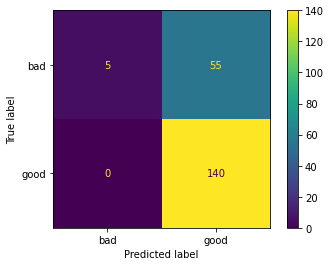

              precision    recall  f1-score   support

         bad       1.00      0.08      0.15        60
        good       0.72      1.00      0.84       140

    accuracy                           0.73       200
   macro avg       0.86      0.54      0.49       200
weighted avg       0.80      0.72      0.63       200



In [35]:
pipe_gb = Pipeline([('pre_processador', pre_processador),
                    ('gb',
                     GradientBoostingClassifier(random_state=420,
                                                learning_rate=0.01,
                                                n_estimators=100))])

# treinar o modelo
pipe_gb.fit(X_train, y_train)

# avaliar o modelo
metricas_classificacao(pipe_gb)

Claramente está dando um underfitting -> não convergiu (nesse caso, precisa de mais estimadores para chegar no ponto de mínimo)

Alterar alguns hiperâmetros:

learning_rate=0.1 -> learning_rate=0.01 (underfitting)

n_estimators=100 -> n_estimators=1000


Métricas de avaliação de treino:
[[156  84]
 [ 14 546]]


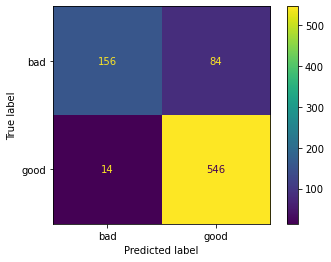

              precision    recall  f1-score   support

         bad       0.92      0.65      0.76       240
        good       0.87      0.97      0.92       560

    accuracy                           0.88       800
   macro avg       0.89      0.81      0.84       800
weighted avg       0.88      0.88      0.87       800


Métricas de avaliação de teste:
[[ 26  34]
 [ 13 127]]


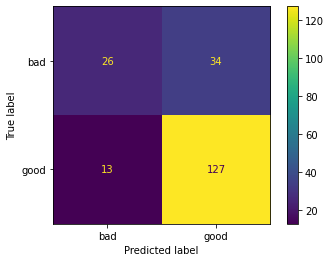

              precision    recall  f1-score   support

         bad       0.67      0.43      0.53        60
        good       0.79      0.91      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



In [36]:
pipe_gb = Pipeline([('pre_processador', pre_processador),
                    ('gb',
                     GradientBoostingClassifier(random_state=420,
                                                learning_rate=0.01,
                                                n_estimators=1000))])

# treinar o modelo
pipe_gb.fit(X_train, y_train)

# avaliar o modelo
metricas_classificacao(pipe_gb)

## XGBoost

Chegamos ao nosso último método de ensemble, o XGBoost (e**X**treme **G**radient **Boost**ing).

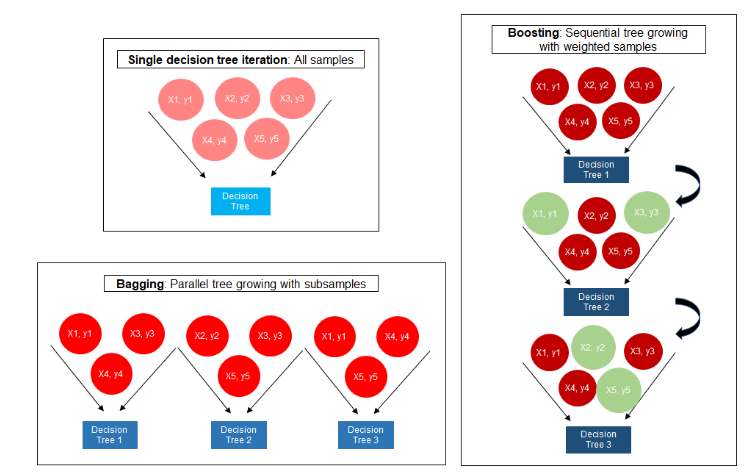

Este método nada mais é que um gradient boosting, mas com algumas importantes modificações que lhe conferem o título de "extreme"! Em particular, duas alterações merecem destaque:

- A adição de procedimentos de regularização (L1 e L2!), o que melhora consideravelmente sua capacidade de generalização;

- A utilização de derivadas de segunda ordem (Hessiano) para o procedimento de gradiente.

Para quem quiser se aventurar mais, sugiro algumas boas leituras:

- [Este](https://shirinsplayground.netlify.app/2018/11/ml_basics_gbm/), explica bem as particularidades do XGBoost, além de dar uma boa introdução ao gradient boosting (o código é em R, então pode ignorar essa parte hehe);

- [Este](https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb), introduz bem o método, enquanto enfativa suas particularidades, com alguns detalhes matemáticos;

- [Este](https://xgboost.readthedocs.io/en/latest/tutorials/model.html), da própria documentação da biblioteca, traz uma explicação legal, e com alguns detalhes matemáticos;

- [Este](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d), com uma discussão mais alto-nível (sem tantos detalhes) sobre o XGBoost e os motivos de seu sucesso.

Infelizmente, o sklearn não tem o XGBoost implementado :(

Mas, felizmente, existe uma biblioteca que o implementou, de maneira totalmente integrada ao sklearn!!

A biblioteca é a [XGBoost](https://xgboost.readthedocs.io/en/latest/).

Para instalar a biblioteca, o de sempre:

`!pip install xgboost`

https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [1]:
!pip install xgboost

     ---------------------------------------- 99.7/99.7 MB 1.5 MB/s eta 0:00:00


In [5]:
# biblioteca específica para o XGBoosting
from xgboost import XGBClassifier

In [6]:
#carregar os dados -> data ingestion
df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

# Definir quem são as variáveis independentes e a variável dependente
X = df.select_dtypes(include=np.number)
y = df["Risk"]

X_train, y_train, X_test, y_test = train_test_split(X, y)

xgb = XGBClassifier(random_state=42)

# treinar o modelo
xgb.fit(X_train, y_train)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [7]:
from sklearn import preprocessing

df = pd.read_csv("../datasets/german_credit_data.csv", index_col=0)

X = df.select_dtypes(include=np.number)
y = df["Risk"]

label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

xgb = XGBClassifier(random_state=42)

# treinar o modelo
xgb.fit(X_train, y_train)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'Target'],
      dtype='object')

In [8]:
# copiando da aula anterior
def metricas_classificacao(estimator, X_train, y_train, X_test, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))
    

In [9]:
# avaliar o modelo
metricas_classificacao(xgb, X_train, y_train, X_test, y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45211 non-null  int64
 1   job        45211 non-null  int8 
 2   marital    45211 non-null  int8 
 3   education  45211 non-null  int8 
 4   default    45211 non-null  int8 
 5   balance    45211 non-null  int64
 6   housing    45211 non-null  int8 
 7   loan       45211 non-null  int8 
 8   contact    45211 non-null  int8 
 9   day        45211 non-null  int64
 10  month      45211 non-null  int8 
 11  duration   45211 non-null  int64
 12  campaign   45211 non-null  int64
 13  pdays      45211 non-null  int64
 14  previous   45211 non-null  int64
 15  poutcome   45211 non-null  int8 
 16  Target     45211 non-null  int8 
dtypes: int64(7), int8(10)
memory usage: 2.8 MB


# Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

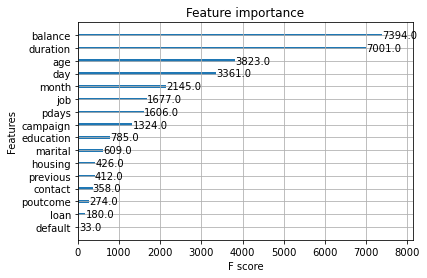

In [69]:
# Importa o método plot_importance do xgboost
from xgboost import plot_importance

plot_importance(xgb);

Não precisa normalizar ou padronizar pois ele é baseado em árvores. As árvores não usam métodos de distância e sim separação dos dados de uma feature

In [73]:
# Vamos considerar apenas as 3 features mais importantes
x_importance = X[['Credit amount', 'Age', 'Duration']]

#### particionar dados
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(x_importance, y, stratify=y, test_size=0.2, random_state=42) 

In [74]:
xgb = XGBClassifier(n_estimators=1000)

xgb.fit(X_train, y_train)

[21:32:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [75]:
# Avaliar o modelo

# Faz a predição do modelo treinado na base de teste
y_pred_xgb = xgb.predict(X_test)

# Verifica o modelo com o classification_report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7985
           1       0.47      0.27      0.34      1058

    accuracy                           0.88      9043
   macro avg       0.69      0.61      0.64      9043
weighted avg       0.86      0.88      0.86      9043



____
____
____

## Bora praticar?
Admission_Predict.csv

Com os dados do arquivo Admission_Predict.csv realize uma classificação dos alunos que possuem chance maior que 0.8 de admissão e dos que possuem chance menor ou igual a 0.8. Treins os modelos de boost aprendidos na aula de hoje.

____
____
____

## Mini tarefa

Usando o dataset de infarto (heart.csv), obtenha a acurácia de três modelos
- AdaBoost com 100 estimadores
- Gradient Boost com 120 estimadores e taxa de aprendizado de 0.001
- XGBoost com profundidade máxima de 6 e taxa de aprendizado de 0.2  
  
Utilize todas as variáveis presentes no dataset e divida em treino e teste, sendo 20% para teste, com random state igual a 42. Envie o valor encontrado no link do [forms](https://forms.gle/reLfqC8DBC2MBPXR8)

Sobre o dataset:  

- **Age** Idade do paciente  
- **Sex** Gênero do paciente  
- **exang** exercise induced angina (1 = yes; 0 = no)  
- **ca** number of major vessels (0-3)  
- **cp** Chest Pain type chest pain type  
Value 1: typical angina  
Value 2: atypical angina  
Value 3: non-anginal pain  
Value 4: asymptomatic  
- **trtbps** Pressão arterial em repouso (in mm Hg)  
- **chol** Colesterol  
- **fbs** glicemia > 120 mg/dl (1 = true; 0 = false)  
- **rest_ecg** resultados do eletrocardiograma em repouso  
Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- **thalach** Máximo valor de batimentos registrados

- **target** 0= Chances menores de infarto 1= Maiores chances de infarto

In [21]:
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [16]:
df = pd.read_csv("../datasets/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [17]:
# Definir quem são as features e quem é o target

# X = df.select_dtypes(include=np.number) # features
X = df.drop('target', axis=1)
y = df['target'] # target

In [18]:
# particionar os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**AdaBoost**

In [24]:
model_ab = AdaBoostClassifier(n_estimators=100)
model_ab.fit(X_train, y_train)

y_pred = model_ab.predict(X_test) # predição dos dados
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.83      0.77        29
           1       0.82      0.72      0.77        32

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.78      0.77      0.77        61



**Gradient Boost**

In [28]:
model_gb = GradientBoostingClassifier(n_estimators=120, learning_rate=0.001)
model_gb.fit(X_train, y_train)

y_pred = model_gb.predict(X_test) # predição dos dados
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



**XGBoost**

In [38]:
model_xgb = XGBClassifier(max_depth=6, eta=0.2)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test) # predição dos dados
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        29
           1       0.86      0.78      0.82        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



____
____
____